# [1]IMPORTING LIBRARIES AND DATSETS

In [ ]:
import pandas as pd
import numpy as np
import os


In [ ]:
print(os.listdir())

['.config', 'sample_data']


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/1/JEOPARDY_CSV.csv')
data.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data[' Round'].value_counts()
data[' Value'].value_counts()
data[' Category'].value_counts()
data = data[data[' Value']!= 'None']
data['cleaned_value'] = data[' Value'].apply(
                        lambda x: int(x.replace('$','').replace(',','')))
#data.columnsr
data.shape

Jeopardy!           107384
Double Jeopardy!    105912
Final Jeopardy!       3631
Tiebreaker               3
Name:  Round, dtype: int64

In [ ]:
data.describe()

,Show Number,cleaned_value
count,213296.000000,213296.000000
mean,4264.415943,752.595923
std,1386.153625,637.855303
min,1.000000,5.000000
25%,3349.000000,400.000000
50%,4490.000000,600.000000
75%,5393.000000,1000.000000
max,6300.000000,18000.000000


## CLeaning data and Percentiles 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

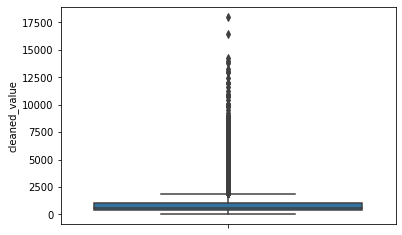

In [ ]:
sns.boxplot(y = 'cleaned_value',data = data)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


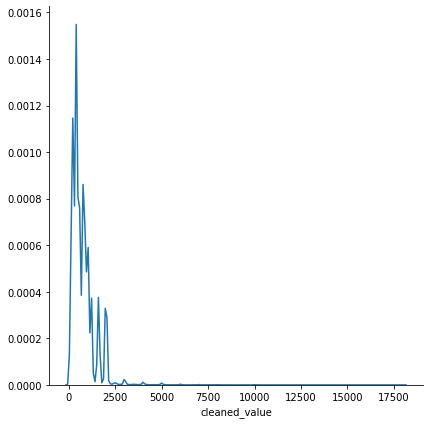

In [ ]:
#pdf of trip-times after removing the outliers
sns.FacetGrid(data,size=6) \
      .map(sns.kdeplot,"cleaned_value") \
      .add_legend();
plt.show();

In [ ]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =data["cleaned_value"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 5
10 percentile value is 200
20 percentile value is 300
30 percentile value is 400
40 percentile value is 400
50 percentile value is 600
60 percentile value is 800
70 percentile value is 800
80 percentile value is 1000
90 percentile value is 1600
100 percentile value is  18000


In [ ]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = data["cleaned_value"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 1600
91 percentile value is 1600
92 percentile value is 1600
93 percentile value is 2000
94 percentile value is 2000
95 percentile value is 2000
96 percentile value is 2000
97 percentile value is 2000
98 percentile value is 2000
99 percentile value is 2800
100 percentile value is  18000


In [ ]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =data["cleaned_value"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])


99.0 percentile value is 2800
99.1 percentile value is 3000
99.2 percentile value is 3000
99.3 percentile value is 3000
99.4 percentile value is 3200
99.5 percentile value is 3800
99.6 percentile value is 4000
99.7 percentile value is 4500
99.8 percentile value is 5000
99.9 percentile value is 6000
100 percentile value is  18000


## GETTING TARGET VARIABLE

__The task is to predict value here,and if we see then there are 150 unique values in the dataset comprising of 
216930 data points.Which means we can either treat this as a regression problem,with target value as a continous variable or creating bins to treat as a multi class classification problem which can give us a better accuracy and assesment of the conditions__

In [ ]:
def binning(value):
    if value < 1000:
        return np.round(value, -2)
    elif value < 10000:
        return np.round(value, -3)
    else:
        return np.round(value, -4)

data['ValueBins'] = data['cleaned_value'].apply(binning)

In [ ]:

from warnings import filterwarnings
filterwarnings('ignore')

import pandas as pd
import joblib
import re
import string
import spacy

from nltk.corpus import stopwords
from collections import Counter

%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

import matplotlib.pyplot as plt
import numpy as np

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import train_test_split

import plotly.express as px
import plotly.graph_objects as go

from plotly.offline import plot

# [2] PREPROCESSING DATA 

In [ ]:
#CLASS FOR CLEANING AND LEMMATIZING THE  TEXT
class DataManager:
    def __init__(self, dataframe: pd.DataFrame, target_column_name: str):
        super(DataManager, self).__init__()
        self.dataframe = dataframe.copy()
        self.target_column_name = target_column_name
        sw = stopwords.words('english')
        self.stop_words = Counter(sw)
        self.nlp = spacy.load('en_core_web_sm')
        self.question_lengths = None
        self.word_cloud = None

    def text_cleaner(self, text: str):
        text = text.lower()
        if len(text.split()) > 3:
            text = ' '.join(
                [word for word in text.split() if word not in self.stop_words])

            text = re.sub(r"\s+", " ", text)
            text = re.sub(r"\w*\d\w*", "", text)
            text = re.sub(r"[%s]" % re.escape(string.punctuation), " ", text)
            text = text.encode('ascii', 'replace').decode()
            text = re.sub(r"  +", " ", text)
        else:
            text = np.nan
        return text

    def text_lemmatizer(self, text):
        sentence = list()
        document = self.nlp(text)
        for word in document:
            sentence.append(word.lemma_)
        return ' '.join(sentence)

    def clean_data(self):
        print('Cleaning text ...')
        self.dataframe[self.target_column_name] = self.dataframe[
            self.target_column_name].apply(lambda x: self.text_cleaner(x))
        self.dataframe.dropna(axis=0, inplace=True)
        print('Done !\nNow lemmatizing ...')
        self.dataframe[self.target_column_name] = self.dataframe[
            self.target_column_name].apply(lambda x: self.text_lemmatizer(x))
        print('Done !')
        self.dataframe[self.target_column_name] = self.dataframe[
            self.target_column_name].str.replace('-PRON-', '')

    def plot_word_length_distribution(self):
        self.question_lengths = [
            len(q) for q in self.dataframe[self.target_column_name].values
        ]
        plt.figure(figsize=(11, 5))
        plt.hist(self.question_lengths, bins=50)
        plt.xlim(
            np.min(self.question_lengths) - 10,
            np.max(self.question_lengths) + 10)
        plt.title('Distribution of lengths of questions')
        plt.xlabel('# of charecters in a question')
        plt.ylabel('Number of questions')
        plt.show()

    def show_wordcloud(self):
        self.word_cloud = WordCloud(stopwords=STOPWORDS,
                                    max_words=1000,
                                    max_font_size=48,
                                    random_state=0).generate(
                                        str(data[self.target_column_name]))

        fig = plt.figure(figsize=(14, 9))
        plt.imshow(X=self.word_cloud, aspect='auto')
        plt.axis('off')
        plt.show()

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:

target_column_name = ' Question'
data_manager = DataManager(
    dataframe=data, 
    target_column_name=target_column_name
)

In [ ]:
data_manager.clean_data()

Cleaning text ...
Done !
Now lemmatizing ...
Done !


In [ ]:

#data_manager.show_wordcloud()

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/1/final.csv')

In [ ]:

data = data[data['ValueBins']!=20]

In [ ]:
print("Total number of categories:", data[' Value'].unique().shape[0])
print("Number of categories after binning:", data['ValueBins'].unique().shape[0])
print("\nBinned Categories:", data['ValueBins'].unique())

Total number of categories: 148
Number of categories after binning: 21

Binned Categories: [ 2  4  6  8 11 10 12 14  1  3  5 13 16  7 17 15 19  9 18  0 20]


In [ ]:
#splitting the data for train,cross validation and test
#data = data.sort_values(by=[' Air Date'])
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
data['ValueBins'] = label_encoder.fit_transform(data['ValueBins'])
data['ValueBins'].value_counts()

4     40650
10    32659
8     30751
2     29236
11    24402
6     19671
5      8700
1      8628
3      8321
12     1060
13      579
14      314
7       199
15      137
9       109
16       59
19       44
17       41
18       14
0        12
20        2
Name: ValueBins, dtype: int64

In [ ]:
#splitting the data with respect
train,test,y_train,y_test = train_test_split(data[' Question'],data['ValueBins'],stratify = data['ValueBins'],
                                            random_state = 42)
train,cv,y_train,y_cv = train_test_split(train,y_train,stratify =y_train,random_state=42)

In [ ]:
len(y_train.unique())
len(y_cv.unique())
len(y_test.unique())

20

In [ ]:
print(train.shape)
print(cv.shape)
print(test.shape)

(115643,)
(38548,)
(51397,)


# CLASS DISTRIBUTION IN ALL THREE

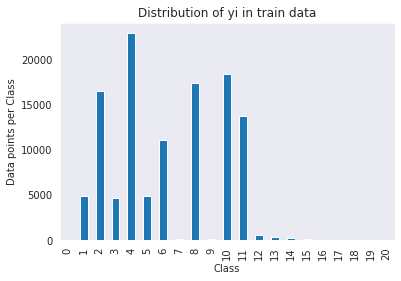

Number of data points in class 5 : 22866 ( 19.773 %)
Number of data points in class 11 : 18370 ( 15.885 %)
Number of data points in class 9 : 17297 ( 14.957 %)
Number of data points in class 3 : 16445 ( 14.22 %)
Number of data points in class 12 : 13726 ( 11.869 %)
Number of data points in class 7 : 11065 ( 9.568 %)
Number of data points in class 6 : 4894 ( 4.232 %)
Number of data points in class 2 : 4853 ( 4.197 %)
Number of data points in class 4 : 4681 ( 4.048 %)
Number of data points in class 13 : 596 ( 0.515 %)
Number of data points in class 14 : 325 ( 0.281 %)
Number of data points in class 15 : 176 ( 0.152 %)
Number of data points in class 8 : 112 ( 0.097 %)
Number of data points in class 16 : 77 ( 0.067 %)
Number of data points in class 10 : 62 ( 0.054 %)
Number of data points in class 17 : 33 ( 0.029 %)
Number of data points in class 20 : 25 ( 0.022 %)
Number of data points in class 18 : 23 ( 0.02 %)
Number of data points in class 19 : 8 ( 0.007 %)
Number of data points in cla

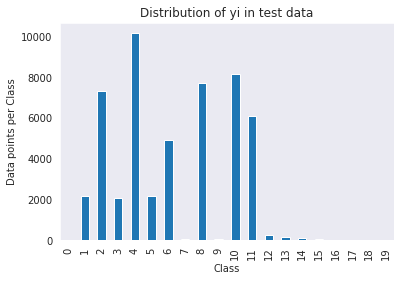

Number of data points in class 5 : 10162 ( 19.772 %)
Number of data points in class 11 : 8165 ( 15.886 %)
Number of data points in class 9 : 7688 ( 14.958 %)
Number of data points in class 3 : 7309 ( 14.221 %)
Number of data points in class 12 : 6100 ( 11.868 %)
Number of data points in class 7 : 4918 ( 9.569 %)
Number of data points in class 6 : 2175 ( 4.232 %)
Number of data points in class 2 : 2157 ( 4.197 %)
Number of data points in class 4 : 2080 ( 4.047 %)
Number of data points in class 13 : 265 ( 0.516 %)
Number of data points in class 14 : 145 ( 0.282 %)
Number of data points in class 15 : 79 ( 0.154 %)
Number of data points in class 8 : 50 ( 0.097 %)
Number of data points in class 16 : 34 ( 0.066 %)
Number of data points in class 10 : 27 ( 0.053 %)
Number of data points in class 17 : 15 ( 0.029 %)
Number of data points in class 20 : 11 ( 0.021 %)
Number of data points in class 18 : 10 ( 0.019 %)
Number of data points in class 19 : 4 ( 0.008 %)
Number of data points in class 1 

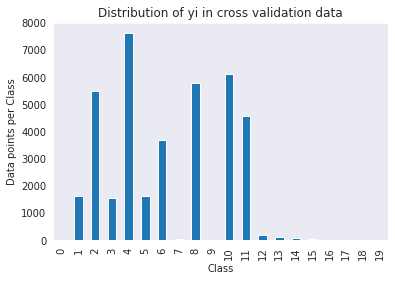

Number of data points in class 5 : 7622 ( 19.773 %)
Number of data points in class 11 : 6124 ( 15.887 %)
Number of data points in class 9 : 5766 ( 14.958 %)
Number of data points in class 3 : 5482 ( 14.221 %)
Number of data points in class 12 : 4576 ( 11.871 %)
Number of data points in class 7 : 3688 ( 9.567 %)
Number of data points in class 6 : 1631 ( 4.231 %)
Number of data points in class 2 : 1618 ( 4.197 %)
Number of data points in class 4 : 1560 ( 4.047 %)
Number of data points in class 13 : 199 ( 0.516 %)
Number of data points in class 14 : 109 ( 0.283 %)
Number of data points in class 15 : 59 ( 0.153 %)
Number of data points in class 8 : 37 ( 0.096 %)
Number of data points in class 16 : 26 ( 0.067 %)
Number of data points in class 10 : 20 ( 0.052 %)
Number of data points in class 17 : 11 ( 0.029 %)
Number of data points in class 18 : 8 ( 0.021 %)
Number of data points in class 20 : 8 ( 0.021 %)
Number of data points in class 19 : 2 ( 0.005 %)
Number of data points in class 1 : 2

In [ ]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = y_train.value_counts().sort_index()
test_class_distribution = y_test.value_counts().sort_index()
cv_class_distribution = y_cv.value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], 
          '(', np.round((train_class_distribution.values[i]/y_train.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i],
          '(', np.round((test_class_distribution.values[i]/y_test.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()


# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], 
          '(', np.round((cv_class_distribution.values[i]/y_cv.shape[0]*100), 3), '%)')


# [1.] Machine Learning Models

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from joblib import dump,load

In [ ]:
#BoW
count_vect = CountVectorizer(ngram_range = (1,2),min_df = 5) #in scikit-learn
count_vect.fit(train.values)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

train_vect = count_vect.transform(train.values)
cv_vect = count_vect.transform(cv.values)
test_vect = count_vect.transform(test.values)

print("the type of count vectorizer ",type(train_vect))
print("the shape of Train BOW vectorizer ",train_vect.get_shape())
print("the shape of Cross validation BOW vectorizer is:",cv_vect.get_shape())
print("the shape of Test BOW vectorizer ",test_vect.get_shape())
print("the number of unique words ", train_vect.get_shape()[1])

some feature names  ['aa', 'aaron', 'aaron burr', 'ababa', 'abandon', 'abba', 'abbey', 'abbott', 'abbreviate', 'abbreviation']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of Train BOW vectorizer  (56250, 15708)
the shape of Cross validation BOW vectorizer is: (18750, 15708)
the shape of Test BOW vectorizer  (25000, 15708)
the number of unique words  15708


In [ ]:
dump(count_vect,'count_vect.pkl')

['count_vect.pkl']

In [ ]:
#tfidf
vect = TfidfVectorizer(ngram_range = (1,3),min_df = 5)#this ensures that  word which is occuring less than 10 times gets discarded

vect.fit(train.values)#vectorizer reading and forming all the vocabalury from training dataset

train_set_tfidf = vect.transform(train.values)
cv_set_tfidf = vect.transform(cv.values)
test_set_tfidf = vect.transform(test.values)
#transforming the data after learning the vocabalury this creates sparse matrices

print('After Vectorization:')
print('\nsize of training dataset is {}'.format(train_set_tfidf.shape))
print('size of cv dataset is :',cv_set_tfidf.shape)
print("size of test dataset is {}".format(test_set_tfidf.shape))

After Vectorization:

size of training dataset is (56250, 16205)
size of cv dataset is : (18750, 16205)
size of test dataset is (25000, 16205)


In [ ]:
dump(vect,'tfidf_vect.pkl')

['tfidf_vect.pkl']

## LOGISTIC REGRESSION

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
warnings.filterwarnings("ignore")
import datetime as dt
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    

    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row

    
    labels = [i for i in range(1,21)]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [ ]:
# we need to generate 2 numbers and the sum of numbers should be 1
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((len(y_test),20))
for i in range(len(y_test)):
    rand_probs = np.random.rand(1,20)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

pred_y =np.argmax(predicted_y, axis=1)


Log loss on Test Data using Random Model 3.294246174893557


-------------------- Confusion matrix --------------------


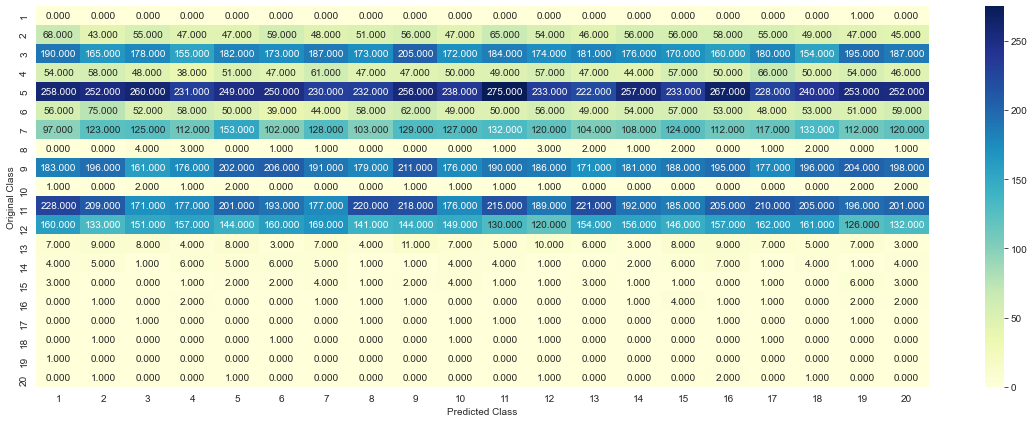

-------------------- Precision matrix (Columm Sum=1) --------------------


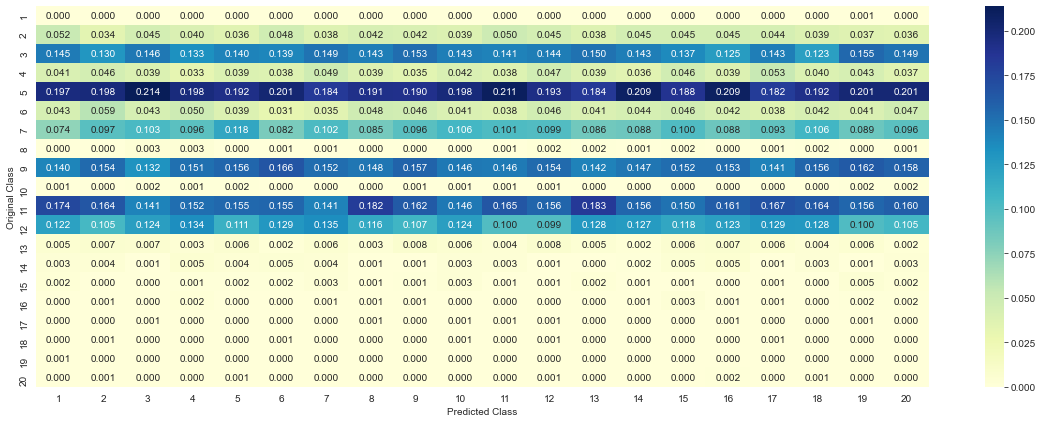

-------------------- Recall matrix (Row sum=1) --------------------


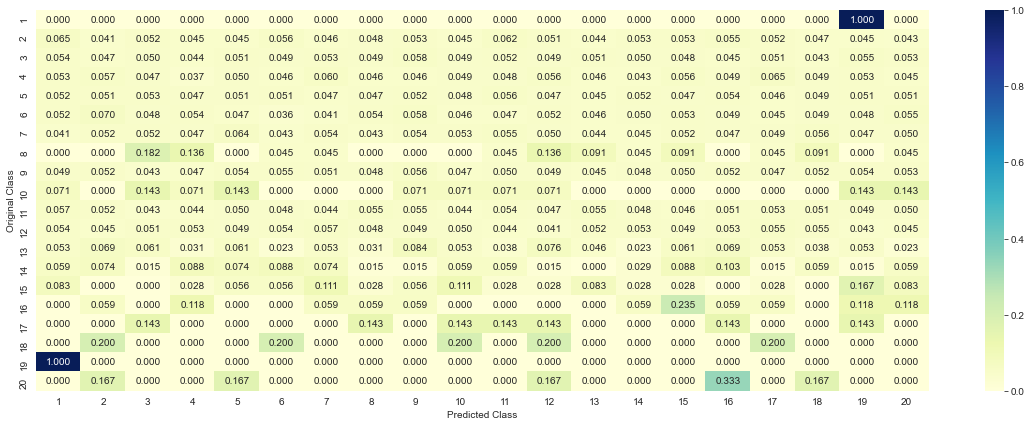

In [ ]:

plot_confusion_matrix(y_test, pred_y)

In [ ]:
"""This function takes in input the list of values of alpha to be tuned

    and training and cross validation dataset and returns the list with cross validation error for every alpha"""

def classifier(alpha,train,Y_train,cv,Y_cv):
    log_error_cv = []#list for apending losses
    log_error_tr = []#list for appending training loss

    for i in alpha:
        clf = SGDClassifier(alpha = i,penalty= 'l2',loss = 'log',random_state = 42)#the logestic regression classifier
        clf.fit(train,Y_train)

    #building the calbirated classifier for exact probabilitiies
        sig_clf = CalibratedClassifierCV(clf,method = 'sigmoid')
        sig_clf.fit(train,Y_train)
        predict_cv = sig_clf.predict_proba(cv)
        predict_tr = sig_clf.predict_proba(train)

    #computing the loss
        loss_tr = log_loss(Y_train,predict_tr,labels =clf.classes_,eps = 1e-15)#loss on training data
        loss_cv = log_loss(Y_cv,predict_cv,labels = clf.classes_,eps = 1e-15)#loss on cross validation data
        log_error_cv.append(loss_cv)
        log_error_tr.append(loss_tr)
        print('for values of alpha  = ',i,'The log loss for cross validation data is',loss_cv)

    #plotting the results
    plt.figure(figsize = (12,6))
    plt.plot(alpha,log_error_tr,'r',label = 'Training ')
    plt.plot(alpha,log_error_cv,'g',label = 'Cross Validation')
    plt.xscale('log')
    plt.grid()
    plt.title("Error for each alpha")
    plt.xlabel("log of alpha's")
    plt.ylabel("Error measure")
    plt.legend(loc = 'best')
    plt.show()

    return log_error_cv #function will return cross validation error

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
warnings.filterwarnings("ignore")
import datetime as dt
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

for values of alpha  =  1e-07 The log loss for cross validation data is 2.1216313602876897
for values of alpha  =  1e-06 The log loss for cross validation data is 2.1211776599657615
for values of alpha  =  1e-05 The log loss for cross validation data is 2.1202389664190933
for values of alpha  =  0.0001 The log loss for cross validation data is 2.1164802954223365
for values of alpha  =  0.001 The log loss for cross validation data is 2.112501396954875
for values of alpha  =  0.01 The log loss for cross validation data is 2.1185040609525627
for values of alpha  =  0.1 The log loss for cross validation data is 2.118344407616621
for values of alpha  =  1 The log loss for cross validation data is 2.117704546206784
for values of alpha  =  10 The log loss for cross validation data is 2.1176811171577343
for values of alpha  =  100 The log loss for cross validation data is 2.1176804575412986
for values of alpha  =  1000 The log loss for cross validation data is 2.1176805763955477
for values of 

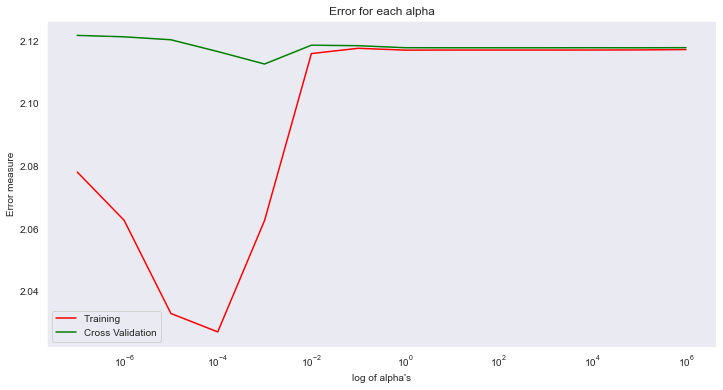

In [ ]:
alpha = [10 ** x for x in range(-7, 7)] # hyperparam for SGD classifier.
lreg_cv_error = classifier(alpha,train_vect,y_train,cv_vect,y_cv)

For values of best alpha =  0.001 The train log loss is: 2.062575457726956
For values of best alpha =  0.001 The cross validation log loss is: 2.112501396954875
For values of best alpha =  0.001 The test validation log loss is: 2.110934901755425
Total number of data points : 25000
-------------------- Confusion matrix --------------------


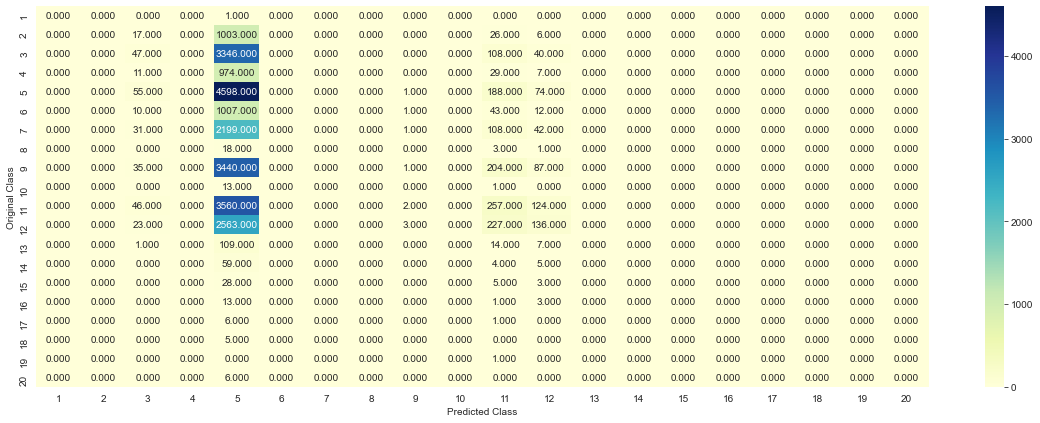

-------------------- Precision matrix (Columm Sum=1) --------------------


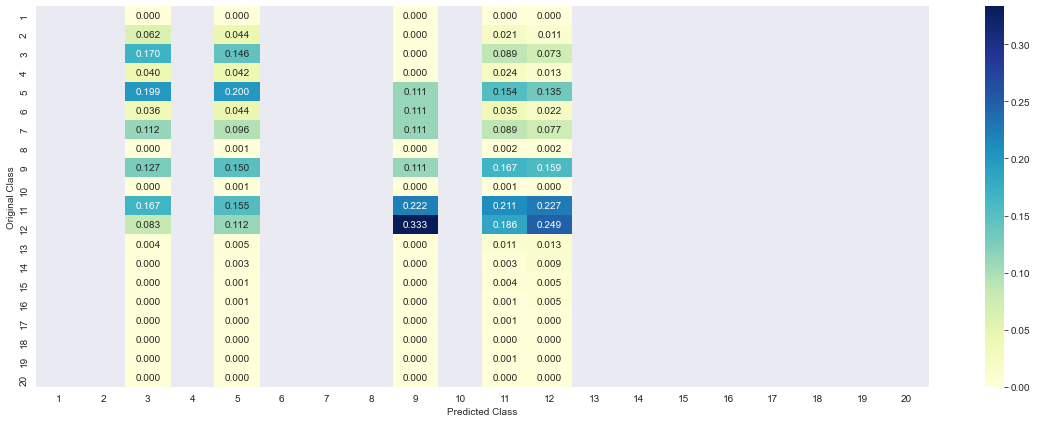

-------------------- Recall matrix (Row sum=1) --------------------


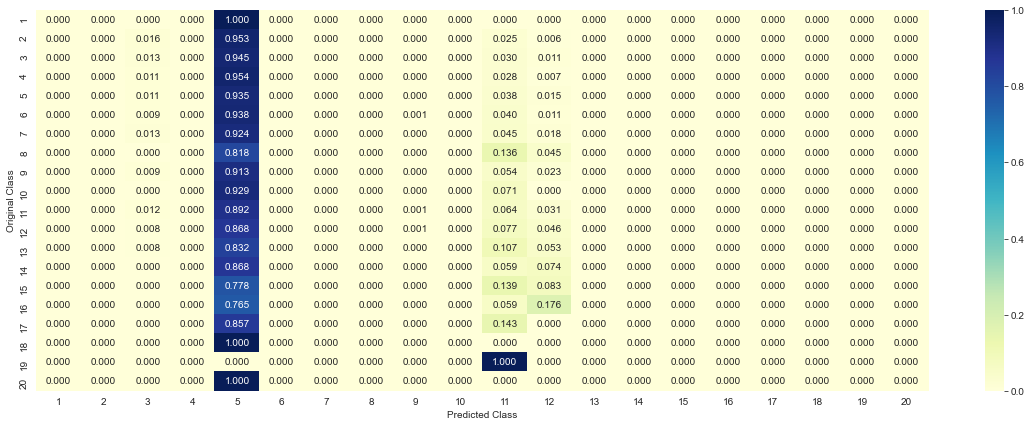

In [ ]:
#funtion for computing the best values on test data

best_alpha = np.argmin(lreg_cv_error)#best value of the hyperparameter
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_vect,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_vect,y_train)
 #=================================================================
predict_y = sig_clf.predict_proba(train_vect)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, 
                labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_vect)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, 
                                            predict_y, labels=clf.classes_, eps=1e-15))
#======================================================================
predict_y = sig_clf.predict_proba(test_vect)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, 
                                            predict_y, labels=clf.classes_, eps=1e-15))

predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# LOGISTIC REGRESSION ON TFIDF FEATURES

for values of alpha  =  1e-07 The log loss for cross validation data is 2.1234681210951405
for values of alpha  =  1e-06 The log loss for cross validation data is 2.1222820415440355
for values of alpha  =  1e-05 The log loss for cross validation data is 2.1182470772809134
for values of alpha  =  0.0001 The log loss for cross validation data is 2.1130054922898536
for values of alpha  =  0.001 The log loss for cross validation data is 2.1149191440183874
for values of alpha  =  0.01 The log loss for cross validation data is 2.118093424860491
for values of alpha  =  0.1 The log loss for cross validation data is 2.1191795410327763
for values of alpha  =  1 The log loss for cross validation data is 2.119088667255209
for values of alpha  =  10 The log loss for cross validation data is 2.119080017200526
for values of alpha  =  100 The log loss for cross validation data is 2.119076246783131
for values of alpha  =  1000 The log loss for cross validation data is 2.1189844552300494
for values of a

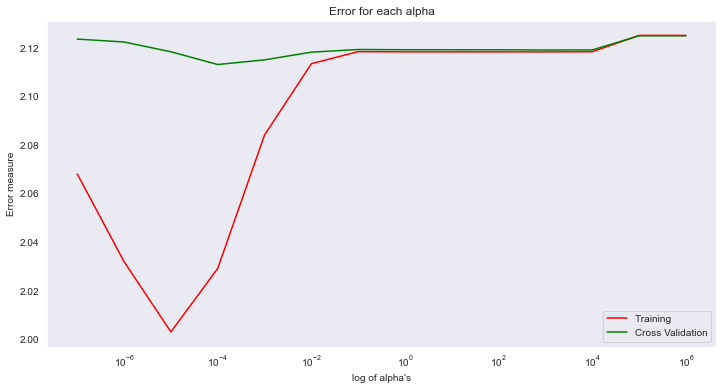

In [ ]:
alpha = [10 ** x for x in range(-7, 7)] # hyperparam for SGD classifier.
lreg_cv_error = classifier(alpha,train_set_tfidf,y_train,cv_set_tfidf,y_cv)


For values of best alpha =  0.0001 The train log loss is: 2.0270389991750455
For values of best alpha =  0.0001 The cross validation log loss is: 2.1164802954223365
For values of best alpha =  0.0001 The test log loss is: 2.1136812281216084
Total number of data points : 25000
-------------------- Confusion matrix --------------------


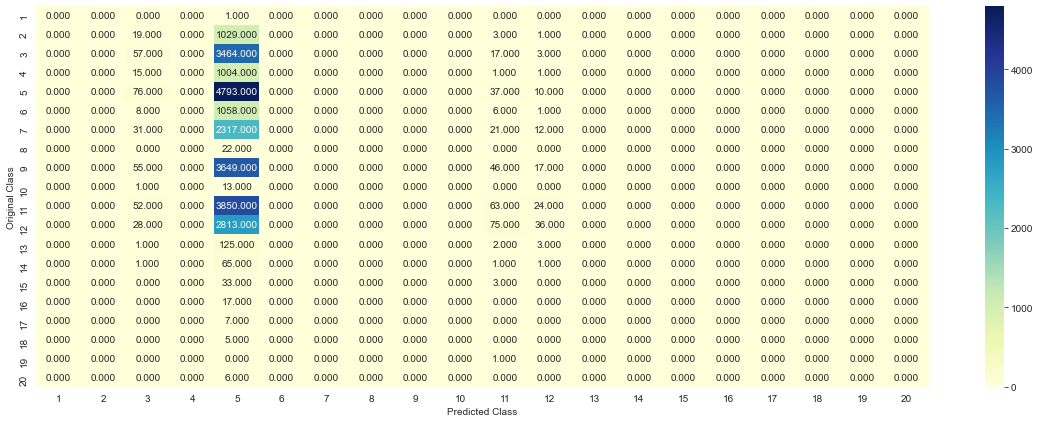

-------------------- Precision matrix (Columm Sum=1) --------------------


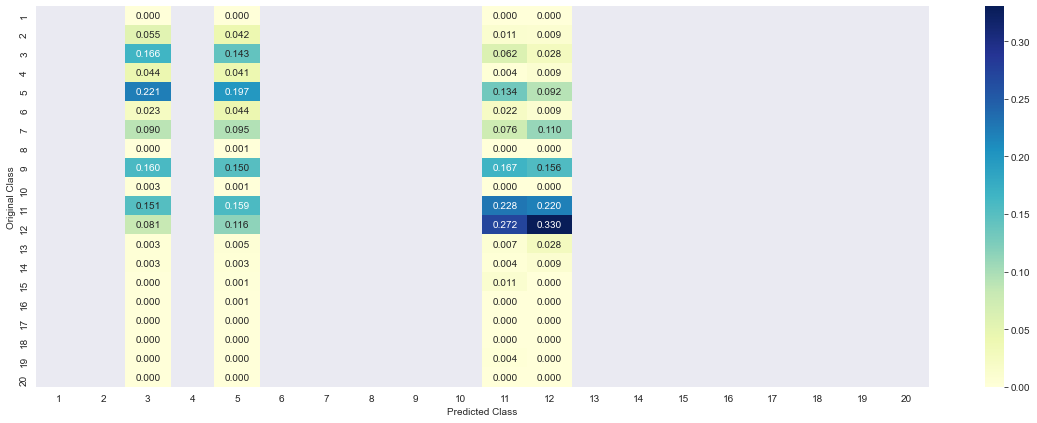

-------------------- Recall matrix (Row sum=1) --------------------


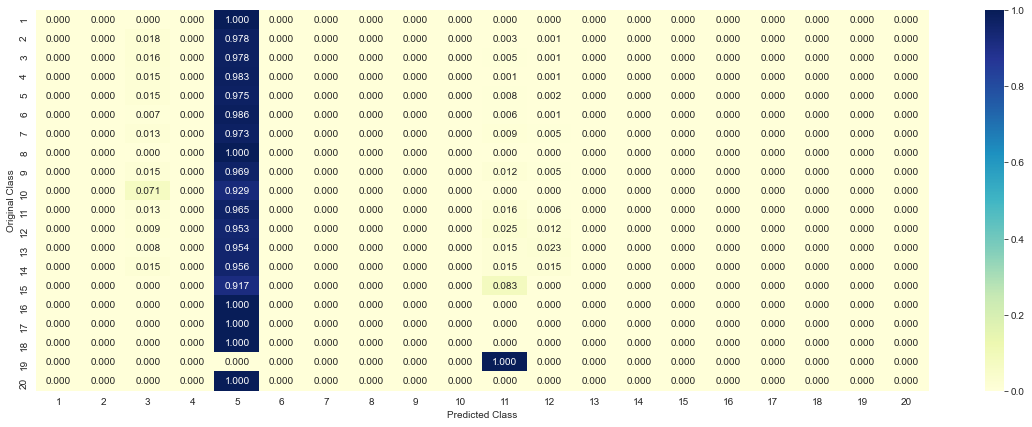

In [ ]:
#funtion for computing the best values on test data

best_alpha = np.argmin(lreg_cv_error)#best value of the hyperparameter
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_vect,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_vect,y_train)
 #=================================================================
predict_y = sig_clf.predict_proba(train_vect)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, 
                labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_vect)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, 
                                            predict_y, labels=clf.classes_, eps=1e-15))
#======================================================================
predict_y = sig_clf.predict_proba(test_vect)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, 
                                            predict_y, labels=clf.classes_, eps=1e-15))

predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# BERT FOR CLASSIFICATION

In [ ]:
from transformers import AutoTokenizer, TFAutoModel


#Downloading the tokenizer and the Albert model for fine tuning

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert=TFAutoModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 18.5MB/s 
     |████████████████████████████████| 3.2MB 50.6MB/s 
     |████████████████████████████████| 890kB 43.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=bb67964efa43ce296c1a72e8e958838a2390e6b9ee85b18bab3e0e4203fda408
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
#ADD all the variable for the Transformer model 

SEQ_length=512

#Lets create the X and Y matrix from the Df train set 

Xids=np.zeros((train.shape[0],SEQ_length))
Xmask=np.zeros((train.shape[0],SEQ_length))
y=np.zeros((train.shape[0],1))

#Preparing the test dataframe

Xids_test=np.zeros((test.shape[0],SEQ_length))
Xmask_test=np.zeros((test.shape[0],SEQ_length))

In [ ]:
for i,sequence in enumerate(train):
    tokens=tokenizer.encode_plus(sequence,max_length=SEQ_length,padding='max_length',add_special_tokens=True,
                           truncation=True,return_token_type_ids=False,return_attention_mask=True,
                           return_tensors='tf')
    
    Xids[i,:],Xmask[i,:],y[i,0]=tokens['input_ids'],tokens['attention_mask'],y_train.values[i]

In [ ]:
for i,sequence in enumerate(test):
    tokens=tokenizer.encode_plus(sequence,max_length=SEQ_length,padding='max_length',add_special_tokens=True,
                           truncation=True,return_token_type_ids=False,return_attention_mask=True,
                           return_tensors='tf')
    
    Xids_test[i,:],Xmask_test[i,:]=tokens['input_ids'],tokens['attention_mask']

In [ ]:
#Check if the GPU is avalaible
import tensorflow as tf 
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:

dataset=tf.data.Dataset.from_tensor_slices((Xids,Xmask,y))

def map_func(input_ids,mask,labels):
    return {'input_ids':input_ids,'attention_mask':mask},labels

dataset=dataset.map(map_func)
dataset=dataset.shuffle(100000).batch(32).prefetch(1000)

DS_size=len(list(dataset))

train=dataset.take(round(DS_size*0.85))
val=dataset.skip(round(DS_size*0.85))

In [ ]:
#Preparing the test dataset

dataset_test=tf.data.Dataset.from_tensor_slices((Xids_test,Xmask_test))

def map_func(input_ids,mask):
    return {'input_ids':input_ids,'attention_mask':mask}

dataset_test=dataset_test.map(map_func)
dataset_test=dataset_test.batch(32).prefetch(1000)

In [ ]:
input_ids=tf.keras.layers.Input(shape=(SEQ_length,),name='input_ids',dtype='int32')
input_mask=tf.keras.layers.Input(shape=(SEQ_length,),name='attention_mask',dtype='int32')

embedding=bert(input_ids,attention_mask=input_mask)[0]
#x=tf.keras.layers.GlobalMaxPool1D()(embedding)
x=tf.keras.layers.GlobalAveragePooling1D()(embedding)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(128,activation='relu')(x)
x=tf.keras.layers.Dropout(0.3)(x)
x=tf.keras.layers.Dense(64,activation='relu')(x)
output=tf.keras.layers.Dense(20,activation='softmax')(x)


model=tf.keras.Model(inputs=[input_ids,input_mask],outputs=output)

model.layers[2].trainable=False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 768)          0           tf_bert_model[0][0]          

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer='adam',metrics=[tf.keras.metrics.CategoricalCrossentropy()])

In [ ]:
history=model.fit(train,validation_data=val,epochs=20)